# Intro

#### This Jupyter Notebook was used to calculate Nearest Neighbor Distances from hand-annotated Filopodia lists to PRG2 spots within the same neuron and controls, by randomly placing thespots within a neuronal binary mask. Prerequisites are: 
#### - List of Filopodia Coordinates (tab delimited columns: Name	X	Y	Channel	Frame), coordinates as µm
#### - List of PRG2 spots (tab delimited columns: Name	X	Y	Frame)
#### - binary masks (tif format, black background) 

## import functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imsave
import tifffile as tiff
from scipy import signal
from scipy import misc
import scipy.fftpack
from scipy import stats
from scipy import signal
import os
from scipy.spatial import distance_matrix
import random

## Define Helper Functions

#### define bining function

In [2]:
from scipy.stats import binned_statistic

def binData(inData,firstcol,lastcol,minbin,maxbin,nbins):
    myArray=inData.as_matrix()
    
    numrows = len(myArray)
    numcols = len(myArray[0]) #[0] for cols. otherwise rows
    if (lastcol=="max"):
        lastcol=numcols

    for j in range(firstcol, lastcol):
       

        data = myArray[:,j]
        bin_means = binned_statistic(data, data, statistic="count", bins=nbins, range=(minbin, maxbin))[0]
        bin_edges= binned_statistic(data, data, statistic='count', bins=nbins, range=(minbin, maxbin))[1]
        binnumber= binned_statistic(data, data, statistic='count', bins=nbins, range=(minbin, maxbin))[2]
        bin_middle=bin_edges[0:len(bin_edges)-1]+((maxbin-minbin)/nbins/2)

        bin_means = np.nan_to_num(bin_means)
        bin_means=bin_means.tolist()       
        
        if (j==0):
            allbins = np.vstack((bin_middle, bin_means))
        else:
            allbins = np.vstack((allbins, bin_means))
        
    allbins=allbins.T
    

    
    matrix=pd.DataFrame(allbins).set_index(0)
    matrix.columns=inData.columns[firstcol:lastcol]
   

    

    return(matrix)

#### define normalization function

In [3]:
def normalize(raw):

    normalized=(raw/raw.mean())#normalize to sum
    normalized=pd.DataFrame(normalized).fillna(0)
    return normalized

# Read Filopodia and PRG2 Spot List ant output path

In [4]:
#filopodia list
filopodialist=pd.read_excel(r"enter filepath\.xlsx", sheet_name=0)

#PRG2 spot list
allInfo=pd.read_excel(r"enter filepath\.xlsx", sheet_name=0)
allInfo.columns=(['Filename','POSITION_X','POSITION_Y',"FRAME","DELAY"])

#output path
path=r"enter filepath"#output path

# Calculate NN

In [ ]:
pixelsize=0.1377745#in µm
filopodiaNames=filopodialist["Name"]
allNNs=[]
NNs=[]  
    
for i in range (0,len(filopodiaNames)):

    filop=(filopodiaNames.values.tolist()[i])#pick filopodium from the list 
    filopLocs=filopodialist.iloc[i]#name of filopodium
    prg2locs=allInfo[allInfo["Filename"]==filop]#list of prg2 spots from same movie, fraem will be picked below
    acuteframe=filopLocs["Frame"]

    subject=filopLocs[["X","Y"]]/pixelsize #coordinates for acute filopodium
    reference=prg2locs[prg2locs['FRAME']==acuteframe][['POSITION_X','POSITION_Y']]/pixelsize #coordinates for acute PRG2 spots in frame of filopodium occurnce

    if(reference.shape[0]==0):
        NN=np.NaN
    else:
        distanceMatrix=distance_matrix(pd.DataFrame(subject).T,reference)[0]#calculate distance matric subject / reference
        NN=np.min(distanceMatrix,axis=0)#calculate NN from distance matrix
              
    NNs=NNs+[NN]
        
allNNs=allNNs+[NNs]
allNNs=pd.DataFrame(allNNs).T
allNNs.index=filopodiaNames
realData=allNNs

#plot figure
fig=plt.figure(figsize=(9,7),dpi=300)
pd.DataFrame(realData.values.flatten()*pixelsize).hist(bins=20,range=[0,3])
plt.xlabel("NN Distance [µm]")
plt.ylabel("Normalized Counts [a.u.]")
plt.title("")
plt.savefig(path+"NN_"+"_spots.png")

#### export NN data to ".csv"

In [10]:
realData.to_csv(path+"enter filename .csv")

## Randomize PRG2

#### N PRG2 spots, will be placed with in the neuron binary mask. N resembles the number of real PRG2 spots from the frame of Filopodium occurance.

#### randomization function and test

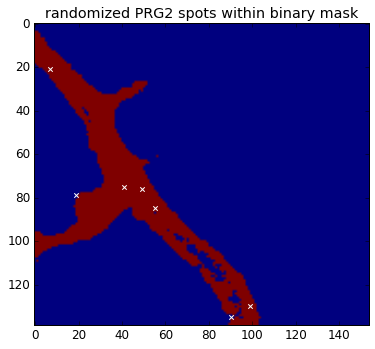

In [11]:
#function to randomize localizations from a pd Datafreme (structure:X/Y/Frame) according to binary mask (only white permitted)

def randomize(locs,mask,frame):#chose frame number or "all" to process all rames, frames start with 1
    randomX=[]
    randomY=[]

    currentLocs=locs[locs["FRAME"]==frame]#only localizations from one frame
    currentMask=mask[frame-1]#only mask from one frame
    for n in range(0, len(currentLocs)):#place localization in the mask N times

        hit=False
        while (hit==False):#if localization was placed outside the mask, try again
            thisX=random.randint(0,mask.shape[2]-1)
            thisY=random.randint(0,mask.shape[1]-1)
            if(currentMask[thisY][thisX]>0):
                hit=True

        randomX=randomX+[thisX]
        randomY=randomY+[thisY]   

    return [randomX,randomY]


#example randomizes localizations within the mask
mask=tiff.imread(r"filepath\.tif")
locs=prg2locs
frame=35
tmp=randomize(locs,mask,frame)
pd.DataFrame(tmp).T

plt.rcParams.update({'font.size': 12})
fig=plt.figure(figsize=(6,6))
plt.title("randomized PRG2 spots within binary mask")
plt.scatter(tmp[0],tmp[1],color="white", marker="x")
plt.imshow(mask[frame])
plt.show()

# calculate randomized NN

#### run simulation once for all filopodia

In [12]:
maskPath=r"enter filepath"#path to binary masks from the neurons 

In [13]:
def doOneSimulation(): 

    pixelsize=0.1377745# in µm
    filopodiaNames=filopodialist["Name"]

    allNNs=[]

    NNs=[]
    # loop through filopodia and and to simulation
    for i in range (0,len(filopodiaNames)):

            
        filop=filopodiaNames.values.tolist()[i]#name of filopodium
        prg2locs=allInfo[allInfo["Filename"]==filop]#list of prg2 spots from same movie, frame will be picked below
        filopLocs=filopodialist.iloc[i]#localizations 
        acuteframe=filopLocs["Frame"]#frame of filopodium occurance

        #randomize the data
        mask=tiff.imread(maskPath+"mask_"+filop)#read binary mask, black background
        randomized=randomize(prg2locs,mask,acuteframe)#place PRG2 spots randomly in mask
        randomized=pd.DataFrame(randomized).T#format the dataframe
        randomized.columns=["X","Y"]#format the dataframe

        subject=filopLocs[["X","Y"]]/pixelsize
        reference=randomized

        #calculate NN !!no "+" in filename!!
        if (reference.shape[0]==0):
            NN=np.NaN

        else:
            NN=np.min(distance_matrix(pd.DataFrame(subject).T,reference)[0],axis=0)#calculate NN fro distance matrix

        NNs=NNs+[NN]
    allNNs=allNNs+[NNs]
    allNNs=pd.DataFrame(allNNs).T
    allNNs.index=filopodiaNames
        
    return allNNs

#### Run 1000x simulations

In [14]:
pixelsize=0.1377745 #in µm
filopodiaNames=filopodiaNames

nSimulations=[]
for repetitions in range(0,1000):
    
    
    nSimulations=nSimulations+[doOneSimulation()[0].tolist()]

saveMe=pd.DataFrame(nSimulations).T
saveMe.index=filopodiaNames
saveMe.to_csv(path+"enter filename .csv")

#### read saved simulations

In [16]:
allSimulations=pd.read_csv(path+"enter filename .csv")

#### Function to calculate confidence intervals

In [17]:
def confidence_interval(array, confidenceLevel):#pass numpy array
    mean = np.mean(array)
    sem= scipy.stats.sem(array)
    upperCI = mean+sem * scipy.stats.t.ppf((1 + confidenceLevel) / 2., len(array)-1)
    lowerCI=  mean-sem * scipy.stats.t.ppf((1 + confidenceLevel) / 2., len(array)-1)
    return mean, upperCI, lowerCI

#### calculate confidence intervals and plot results

In [ ]:
binMin=0 # lowest bin
binMax=3000 # highest bin
nBins=20 # number of bins

tmp=np.array(allSimulations.values[:,1:]*pixelsize*1000).astype(float)# store all simulations in tmp
binnedSimulation=binData(pd.DataFrame(tmp),0,"max",binMin,binMax,nBins) # bin the simulation
normalized=binnedSimulation/binnedSimulation.sum()/(binMax+-binMin)*nBins # normalize the binned simulation

allCIs=[]
for i in range(0,len(normalized.index)):
    CI=confidence_interval(normalized.iloc[i], (1-(0.05/nBins)))# calculate confidence interval for each bin, do Bonferroni Corection
    mean=CI[0]
    upperCI=CI[1]
    lowerCI=[3]
    allCIs=allCIs+[CI]
allCIs=pd.DataFrame(allCIs)   
allCIs.columns=["mean","upperCI","lowerCI"]
allCIs.index=normalized.index

# plot results
plt.rcParams.update({'font.size': 26})
fig=plt.figure(figsize=(9,7),dpi=300)
plt.hist((realData[0]*pixelsize*1000),range=[0,3000],bins=nBins,normed=True,color="gray", zorder=1)
plt.plot(allCIs["mean"],color="black")
plt.fill_between(allCIs.index, allCIs["upperCI"], allCIs["lowerCI"],color="red", zorder=2,alpha=0.5)
#plt.title("NN distance: subject = Filopodia / refference = PRG2 spots, Bonferroni Corrected" )
plt.xlabel("NN Distance [nm]")
plt.ylabel("Normalized Counts [a.u.]")
plt.legend(["Data","spatial randomness"],bbox_to_anchor=(0.61, 1.4), prop={'size': 26})
plt.show
fig.savefig(path+"enter filename .png")


#### Calculate  relative Increase over random

In [ ]:
binMin=0
binMax=3
nBins=20

tmp=np.array(allSimulations.values[:,1:]*pixelsize).astype(float)# store all simulations in tmp
binnedSimulation=binData(pd.DataFrame(tmp),0,"max",binMin,binMax,nBins)# bin the simulation
binnedRealData=binData(pd.DataFrame(realData*pixelsize).astype(float),0,"max",binMin,binMax,nBins) #bin original  measurements
normalizedSim=binnedSimulation/binnedSimulation.sum()/(binMax+-binMin)*nBins #normalize binned simulation
normalizedReal=binnedRealData/binnedRealData.sum()/(binMax+-binMin)*nBins # normalize binned original measurements

allCIs=[]
for i in range(0,len(normalizedSim.index)):
    CI=confidence_interval(normalizedSim.iloc[i], (1-(0.05/nBins)))# calculate confidence interval for each bin, do Bonferroni Corection
    mean=CI[0]
    upperCI=CI[1]
    lowerCI=[3]
    allCIs=allCIs+[CI]
allCIs=pd.DataFrame(allCIs)   
allCIs.columns=["mean","upperCI","lowerCI"]
allCIs.index=normalizedSim.index

# calculate delta increase
delta=normalizedReal.values[:,0]-allCIs[["mean"]].values[:,0]
deltaUpCI=allCIs[["lowerCI"]].values[:,0]-allCIs[["mean"]].values[:,0]
deltaLowCI=allCIs[["upperCI"]].values[:,0]-allCIs[["mean"]].values[:,0]

#calculate relative increase
increasePercent=np.divide(delta,allCIs[["mean"]].values[:,0])
increasePercent=increasePercent*100
increasePercentUpCI=np.divide(deltaUpCI,allCIs[["mean"]].values[:,0])
increasePercentUpCI*100
increasePercentLowCI=np.divide(deltaLowCI,allCIs[["mean"]].values[:,0])
increasePercentLowCI*100
increasePercent=pd.DataFrame([increasePercent.tolist(),increasePercentUpCI.tolist(),increasePercentLowCI.tolist()]).T
increasePercent.columns=allCIs.columns
increasePercent.index=normalizedReal.index


#save relative increase
increasePercent.to_csv(r"enter file path .csv")


increasePercent=increasePercent.set_index("0")
#little trick, to fill also the first bar: all x-axes were reindexed (value[i]-first value and plot position was set to "post")

# plot results
plt.rcParams.update({'font.size': 26})
fig=plt.figure(figsize=(9,7),dpi=300)
plt.step(increasePercent["mean"].index.values-increasePercent["mean"].index.values[0], increasePercent["mean"].values, where="post",  zorder=3, color="black")
plt.fill_between(increasePercent["mean"].index.values-increasePercent["mean"].index.values[0], increasePercent["upperCI"], increasePercent["lowerCI"],color="red", zorder=2,alpha=0.9,step="post",label="Simulated spatial randomness")
plt.fill_between(increasePercent["mean"].index.values-increasePercent["mean"].index.values[0],increasePercent["mean"].values,([0]*len(increasePercent["mean"])) ,color="gray",alpha=1,step="post", zorder=1, label="Measured data")
plt.xlim(0,2.7)
plt.ylim(-220,220)
plt.xlabel("NN distance [µm]",labelpad=15)
plt.ylabel("Change over random [%]",labelpad=15)
plt.legend(bbox_to_anchor=(0.61, 1.4), prop={'size': 26})
plt.show()

#save results
fig.savefig(path+"\\ enter filename .png",bbox_inches = 'tight')
fig.savefig(path+"\\ enter filename  .eps", format='eps',bbox_inches = 'tight')